# Tutorial: Spinal cord tumor segmentation model

This tutorial describes how to apply our pre-trained spinal cord tumor segmentation model to your specific data. 

<img src="images/spinal_cord_tumor_fig1.png">

## Spinal Cord Toolbox Installation

The trained model is available through the Spinal Cord Toolbox (SCT) software (https://github.com/neuropoly/spinalcordtoolbox). In the repository, details are given on how to install the software on your computer. For this demo, the development version downloaded from the Github repository is used. If you already have the software installed you don't need to do this step.

In [ ]:
!git clone https://github.com/neuropoly/spinalcordtoolbox.git sct
!cd sct
!./install_sct
!sct_deepseg

After running the line above the sct_deepseg description should print:
```
--
Spinal Cord Toolbox (git-al/onnx-model-537ab6d02be9cb7f1b67cfa3fb572d2d37ba9ed6)

usage: sct_deepseg [-i <file>] [-o <str>] [-model <str>] [-list-models] [-install-model {t2star_sc,mice_uqueensland_sc,mice_uqueensland_gm,t2_tumor}] [-thr <float>] [-largest LARGEST] [-fill-holes {0,1}]
                   [-v {0,1}] [-h]

Segment an anatomical structure or pathologies according to the specified deep learning model.

INPUT/OUTPUT:
  -i <file>             Image to segment.
  -o <str>              Output file name. In case of multi-class segmentation, class-specific suffixes will be added. By default,suffix '_seg' will be added and output extension will be .nii.gz.

MODELS:
  -model <str>          Model to use. It could either be an official SCT model (in that case, simply enter the name of the model, example: -model t2_sc), or a path to the directory that contains a model,
                        example: -model my_models/model. To list official models, run: sct_deepseg -list-models.To build your own model, follow instructions at: https://github.com/neuropoly/ivado-medical-
                        imaging
  -list-models          Display a list of available models.
  -install-model {t2star_sc,mice_uqueensland_sc,mice_uqueensland_gm,t2_tumor}
                        Install specified model.

PARAMETERS:
  -thr <float>          Binarize segmentation with specified threshold. Set to 0 for no thresholding (i.e., soft segmentation). Default value is model-specific and was set during optimization (more info
                        at https://github.com/sct-pipeline/deepseg-threshold).
  -largest LARGEST      Keep the largest connected-objects from the output segmentation. Specify the number of objects to keep.To keep all objects, set to 0
  -fill-holes {0,1}     Fill small holes in the segmentation.

MISC:
  -v {0,1}              Verbose: 0 = no verbosity, 1 = verbose.
  -h, --help            Show this help message and exit
```

## Download trained model

The model needs to be downloaded prior usage. This step needs to be done only once.

In [8]:
!sct_deepseg -install-model t2_tumor


--
Spinal Cord Toolbox (git-al/onnx-model-537ab6d02be9cb7f1b67cfa3fb572d2d37ba9ed6)


INSTALLING MODEL: t2_tumor
Trying URL: https://osf.io/uwe7k/download?version=1
Downloading: t2_tumor.zip
Status: 100%|██████████████████████████████| 26.6M/26.6M [00:01<00:00, 16.3MB/s]
Creating temporary folder (/tmp/sct-20200609151457.634623-22n1bgmi)
Unzip data to: /tmp/sct-20200609151457.634623-22n1bgmi
Destination folder: /home/andreanne/Documents/spinalcordtoolbox/data/deepseg_models
Checking if folder already exists...
Folder t2_tumor already exists. Removing it...
Removing temporary folders...


## Apply model to a single image

To apply the model to a given image, only one line is required. The parameters `largest` and `fill_holes` with (value 1 or 0 to apply or not) could be added to the following command line. By default, both are applied: the largest object is kept and holes in the segmentation are filled.

In [1]:
!sct_deepseg -i sub0_T2w.nii.gz -model t2_tumor


--
Spinal Cord Toolbox (git-al/onnx-model-537ab6d02be9cb7f1b67cfa3fb572d2d37ba9ed6)


Loaded 1 sagittal volumes of shape [448, 256, 16]

Processing segmentation
-----------------------
Threshold: 0.9
Keep largest objects: 1
Fill holes

Done! To view results, type:
fsleyes sub0_T2w.nii.gz -cm greyscale sub0_T2w_seg.nii.gz -cm red -a 70.0 &



## Display segmentation

The following code helps to visualize the segmentation. The tumor will appear in red.

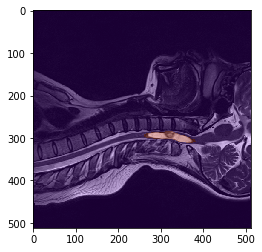

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

# Load the nifty image and extract the numpy array
img = nib.load('sub0_T2w.nii.gz').get_fdata()[:, :, 6]
seg = nib.load('sub0_T2w_seg.nii.gz').get_fdata()[:, :, 6]

plt.figure()
plt.imshow(np.squeeze(img), 'gray', interpolation='none')
plt.imshow(np.squeeze(seg), 'rainbow', interpolation='none', alpha=0.2)
plt.show()

## Apply model on multiple images

The following lines create a bash file to run the model on images from a BIDS directory (https://bids.neuroimaging.io/)

In [25]:
 with open ('process_data.sh', 'w') as rsh:
    rsh.write('''
#!/bin/bash
#
# Pipeline for spinal cord tumor data.
#
# Generate sc segmentation, preprocess data before training.
#
# Note: All images have .nii extension.
#
# Usage:
#   sct_run_batch process_data.sh -path-data PATHDATA -subject-prefix PREFIX -path-outpur OUTPUT
#
#
#
# Uncomment for full verbose
# set -v
#
# Immediately exit if error
set -e

# Exit if user presses CTRL+C (Linux) or CMD+C (OSX)
trap "echo Caught Keyboard Interrupt within script. Exiting now.; exit" INT

# Retrieve input params
SUBJECT=$1

# SCRIPT STARTS HERE
# ==============================================================================
# shellcheck disable=SC1090
#source $FILEPARAM
# Go to results folder, where most of the outputs will be located
cd $PATH_RESULTS
# Copy source images and segmentations
mkdir -p data/derivatives/labels
cd data

cp -r $PATH_DATA/$SUBJECT .
cp -r $PATH_DATA/derivatives/labels/$SUBJECT $PATH_RESULTS/data/derivatives/labels

# Go to data folder
cd $PATH_RESULTS/data/$SUBJECT/anat/
## Setup file names
file_t2w=${SUBJECT}_T2w

sct_deepseg -i ${file_t2w}.nii.gz -model t2_tumor
''')
!chmod +x process_data.sh

Modify the following lines with your own data path, subject prefix and output path.

In [ ]:
!sct_run_batch process_data.sh -path-data path/to/bids/directory -subject-prefix sub -path-output path_output